# 課題1
- コンピュータビジョンに関わるプログラムを作成・実行してください
  - 独自に作ったもの，講義で扱ったものの改良，インターネットで検索して出てきたもの，
ChatGPTに出力させたもの，等なんでも構いません
  - 最新の技術を利用したり，独自のデータを使ったり，独自の改良を加えたものは高く評価します
  - 必ずGoogle Colab上で実行し，実行結果が表示された状態のノートブックを作成してください


## 出典
- 元になったプログラムの出典をこの下のセルに記載してください
- Webの情報を利用した場合にはURLを，ChatGPTなどAIシステムを利用して作成した場合には使用したAIシステムを記載
- 独自のプログムの場合は記載不要

ChatGPT→

参考にした損失関数→https://yaakublog.com/crossentropy_binarycrossentropy

参考にしたプログラム→https://qiita.com/gensal/items/4be65d9b36fac02f877e

## プログラム
- 以下，プログラムを書いて実行してください
- 足りなければセルは自由に増やして構いません

In [1]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import transforms
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#cuda
torch.cuda.empty_cache()
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
#ネットワークはcudaにまとめて投げるのでオブジェクト化する
#Discriminatorネットワーク
class Dis(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        #全結合層にする
        self.disnet = nn.Sequential(
            #28*28の画像を入力とした判別器
            nn.Linear(28*28, 1024),
            #Leaky ReLUはデフォだとα=0.01がいいらしい
            nn.LeakyReLU(0.01),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.01),
            nn.Linear(512, 1),
            #本物かどうかの判別なのでSigmoidで二値分類
            nn.Sigmoid()
        )

    def forward(self, img):
        #テンソルをベクトルにする
        input = img.view(img.size(0),-1)
        #あとは順伝播
        y = self.disnet(input)
        return y


In [4]:
#Generatorネットワーク
class Gen(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.gennet = nn.Sequential(
            #ランダムなノイズを入力(100とかにする)
            nn.Linear(100, 512),
            nn.LeakyReLU(0.01),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.01),
            nn.Linear(1024, 28*28),
            #ピクセルなのでTanh
            nn.Tanh()
        )

    def forward(self, noise):
        y = self.gennet(noise)
        #グレースケールなのでチャンネル数は1
        y = y.view(-1, 1, 28, 28)
        return y

In [5]:
#インスタンスをGPUへコピー
dis = Dis().to(device)
gen = Gen().to(device)

#真値のカテゴリが2つならバイナリクロスエントロピーがいいらしい
#たくさんカテゴリがあるならクロスエントロピーがいいらしい
loss = nn.BCELoss()

#パラメータ最適化手法
#学習率とかはデフォでやる
dis_opt = optim.Adam(dis.parameters(), betas=(0.5, 0.999))
gen_opt = optim.Adam(gen.parameters(), betas=(0.5, 0.999))

#データ変換、正規化、読み込み
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, ), (0.5, ))])
dataset = datasets.MNIST("./MNIST/", train=True, download=True, transform=trans)

100%|██████████| 9912422/9912422 [00:00<00:00, 112406281.25it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 34939629.02it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 44478618.26it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 7145734.72it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [6]:
#学習関数
def train(data_load, epochs, batch):
    #50エポック回す
    #Lossの動きを見る用
    lossdata_dis = []
    lossdata_gen = []
    for epoch in range(epochs):
        #イテレーション分回す
        for batch_index, (img, _) in enumerate(data_load):
            batch_index += 1
            #本物の画像を判別器に入力，判定結果を出力
            real_img = img.to(device)
            real_y = dis(real_img)
            #正解ラベル作成
            real_label = torch.ones(real_img.shape[0], 1).to(device=device)
            #偽物の画像を判別機に入力
            #noise
            noise = torch.rand(real_img.shape[0], 100)
            #-1~1へスケーリング
            noise = ((noise - 0.5) / 0.5).to(device=device)
            fake_img = gen(noise)
            fake_y = dis(fake_img)
            fake_label = torch.zeros(fake_img.shape[0], 1).to(device=device)

            #判別機の出力, 正解を結合
            result = torch.cat((real_y, fake_y), 0)
            ans = torch.cat((real_label, fake_label), 0)

            #BCEで損失計算
            #判別器
            dis_loss = loss(result, ans)
            dis_opt.zero_grad()
            dis_loss.backward()
            dis_opt.step()
            lossdata_dis.append(dis_loss.item())

            #生成器
            #偽物の画像を判別機に入力
            #noise
            noise = torch.rand(real_img.shape[0], 100)
            #-1~1へスケーリング
            noise = ((noise - 0.5) / 0.5).to(device=device)
            fake_img = gen(noise)
            fake_y = dis(fake_img)
            label = torch.ones(fake_img.shape[0], 1).to(device=device)

            gen_loss = loss(fake_y, label)
            gen_opt.zero_grad()
            gen_loss.backward()
            gen_opt.step()
            lossdata_gen.append(gen_loss.item())


            if (batch_index +1) % 100 == 0 or batch_index == len(data_load):
                print(f'現在{epoch}エポック{batch_index}イテレーション')
                print(f'判別器のLossは{dis_loss.item()}')
                print(f'生成器のLossは{gen_loss.item()}')

    return lossdata_dis, lossdata_gen

## バッチサイズ→64

In [18]:
#とりあえずこのバッチサイズで学習
epochs = 50
batch = 64
train_load = DataLoader(dataset=dataset, batch_size=batch, shuffle=True)

lossdata_dis, lossdata_gen = train(train_load, epochs, batch)

現在0エポック99イテレーション
判別器のLossは0.28540289402008057
生成器のLossは1.980375051498413
現在0エポック199イテレーション
判別器のLossは0.27699828147888184
生成器のLossは2.277545928955078
現在0エポック299イテレーション
判別器のLossは0.27345624566078186
生成器のLossは1.9840694665908813
現在0エポック399イテレーション
判別器のLossは0.31705230474472046
生成器のLossは2.072939872741699
現在0エポック499イテレーション
判別器のLossは0.330881267786026
生成器のLossは1.8693407773971558
現在0エポック599イテレーション
判別器のLossは0.372692346572876
生成器のLossは2.003990650177002
現在0エポック699イテレーション
判別器のLossは0.3236033320426941
生成器のLossは1.5795681476593018
現在0エポック799イテレーション
判別器のLossは0.3581858277320862
生成器のLossは2.109879493713379
現在0エポック899イテレーション
判別器のLossは0.3721085488796234
生成器のLossは1.5056300163269043
現在0エポック938イテレーション
判別器のLossは0.41463643312454224
生成器のLossは1.4796602725982666
現在1エポック99イテレーション
判別器のLossは0.3909337818622589
生成器のLossは1.882796049118042
現在1エポック199イテレーション
判別器のLossは0.2622108459472656
生成器のLossは1.8860218524932861
現在1エポック299イテレーション
判別器のLossは0.23588964343070984
生成器のLossは2.232531785964966
現在1エポック399イテレーション
判別器のLossは0.40566301345825

## DiscriminatorのLoss遷移

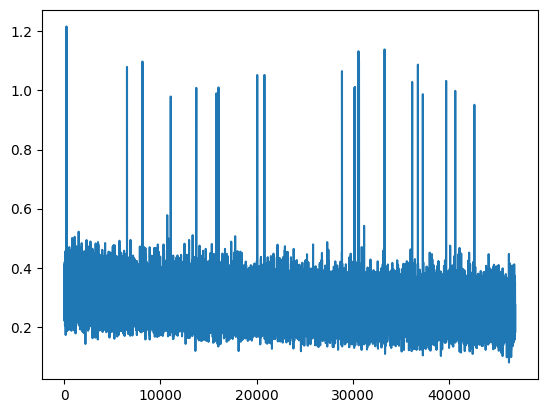

In [19]:
plt.plot(lossdata_dis)

## GeneratorのLoss遷移

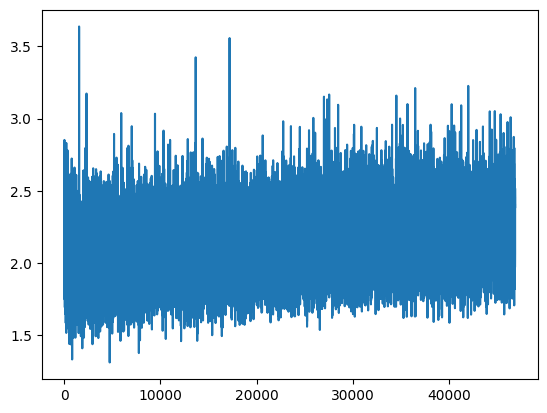

In [20]:
plt.plot(lossdata_gen)

## バッチサイズ64で学習させた生成器で出力させた画像を確認

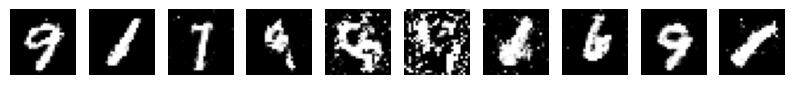

In [21]:

with torch.no_grad():
    noise = torch.randn(10, 100, device=device)
    generated_images = gen(noise)

# 生成された画像を表示
plt.figure(figsize=(10, 10))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(generated_images[i].cpu().detach().numpy().squeeze(), cmap='gray')
    plt.axis('off')
plt.show()

## バッチサイズ→128

In [10]:
#バッチサイズ128
epochs = 50
batch = 128
train_load = DataLoader(dataset=dataset, batch_size=batch, shuffle=True)

lossdata_dis, lossdata_gen = train(train_load, epochs, batch)

現在0エポック99イテレーション
判別器のLossは0.34926292300224304
生成器のLossは1.5609833002090454
現在0エポック199イテレーション
判別器のLossは0.36101025342941284
生成器のLossは1.8658065795898438
現在0エポック299イテレーション
判別器のLossは0.4116200804710388
生成器のLossは1.7897576093673706
現在0エポック399イテレーション
判別器のLossは0.41374683380126953
生成器のLossは1.8264025449752808
現在0エポック469イテレーション
判別器のLossは0.4258906841278076
生成器のLossは1.6449170112609863
現在1エポック99イテレーション
判別器のLossは0.3718861937522888
生成器のLossは1.6334285736083984
現在1エポック199イテレーション
判別器のLossは0.34350621700286865
生成器のLossは1.8628380298614502
現在1エポック299イテレーション
判別器のLossは0.3912540376186371
生成器のLossは1.842786192893982
現在1エポック399イテレーション
判別器のLossは0.34926193952560425
生成器のLossは2.033325672149658
現在1エポック469イテレーション
判別器のLossは0.3820803463459015
生成器のLossは2.1782264709472656
現在2エポック99イテレーション
判別器のLossは0.37259283661842346
生成器のLossは1.8216874599456787
現在2エポック199イテレーション
判別器のLossは0.3562643527984619
生成器のLossは2.011643648147583
現在2エポック299イテレーション
判別器のLossは0.3274852931499481
生成器のLossは1.6296950578689575
現在2エポック399イテレーション
判別器のLossは0.356386691

## DiscriminatorのLoss遷移

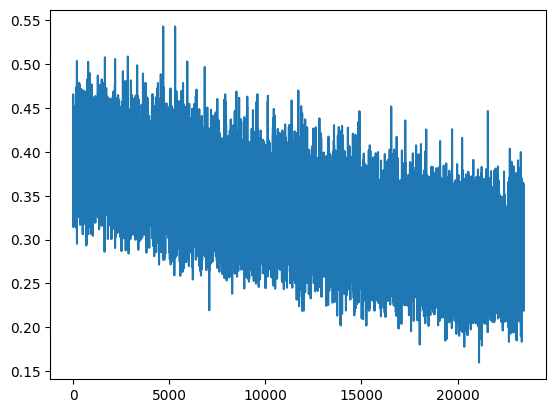

In [11]:
plt.plot(lossdata_dis)

## GeneratorのLoss遷移

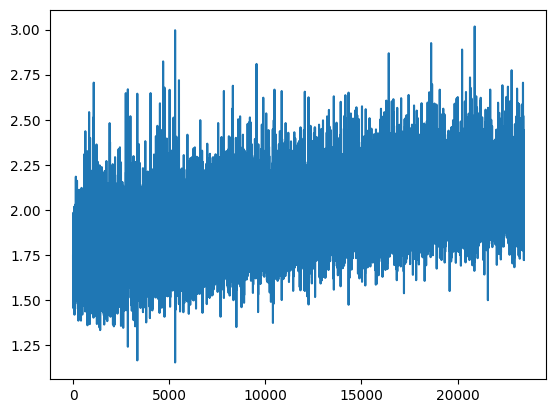

In [12]:
plt.plot(lossdata_gen)

## バッチサイズ128で学習させた生成器で出力させた画像を確認

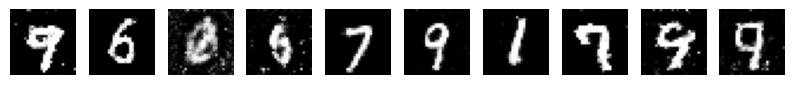

In [14]:
with torch.no_grad():
    noise = torch.randn(10, 100, device=device)
    generated_images = gen(noise)

# 生成された画像を表示
plt.figure(figsize=(10, 10))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(generated_images[i].cpu().detach().numpy().squeeze(), cmap='gray')
    plt.axis('off')
plt.show()

# 課題2
- 課題1のプログラムの内容と実行結果を説明し，このプログラムを応用したシステムを考え具体的に説明してください（1000字以内）
  - テーマは限定しないので，独自の発想で考えてください
  - 新しさ・面白さ・実用性など多面的に評価します
  - 課題1で独自の改良，独自のデータを使っている場合には，その旨を記載してください


このプログラムは、28*28の手書き数字画像データMNISTから学習する敵対生成ネットワークである。敵対生成ネットワークとは、判別器と識別機で競争させるように学習するNNである。今回の判別器は、本物の手書き数字画像と100次元のノイズから生成器が生成した（本物ではない）画像を与えて、その画像が本物かどうかを判定できるように学習させる。一方、生成器は与えられたノイズから、本物に近い手書き数字の画像を生成できるように学習させる。両ネットワークとも線形変換で伝播させており、隠れ層はLeaky ReLUを用いている。入出力層以外の各層のノード数は、学習速度の向上のため2のべき乗にしている。今回はバッチサイズを64と128の2通りで学習させた。

バッチサイズ64、128ともに、Lossは振動していた。GANでは、判別器の精度が上がると、その判別器が間違えるような画像を生成するように生成器は学習を進めるため、Lossの遷移は妥当であると考えられる。また、生成器が出力した画像は、バッチサイズ64ではかなり粗いものもあったが、バッチサイズ128では、なんの数字かよくわからないものがあるものの、おおむね本物の手書き数字画像に見える出力ができていた。このことから、今回はバッチサイズ128の方が良い学習ができたと結論付けることができる。

このプログラムを応用したシステムとして考えられるのは、GANアートによるGANGRAMである。事前学習済みのStabel Diffusion、GPT4が登場してしまった今でこそ、自分が今まで撮影してきた写真フォルダから学習させた、オリジナルの画像を生成できる可能性がある。拡散モデル、Transformerモデルで学習されているデータ数は尋常ではないため、自分のフォルダの写真を追加学習させたところでそれほど出力に影響は現れないだろう。かといって、これらのモデルを1から学習させるのに、自分の写真フォルダの写真数は少なすぎる。ここで登場するのがGANアートであり、Insta●ramのようにGANGRAMをサービス化することで、GANが生成した、個性のある画像を投稿する場を提供する。